Found expert for CLASSIFIER_BC: reward=18.0
Found expert for IQL: reward=3.0


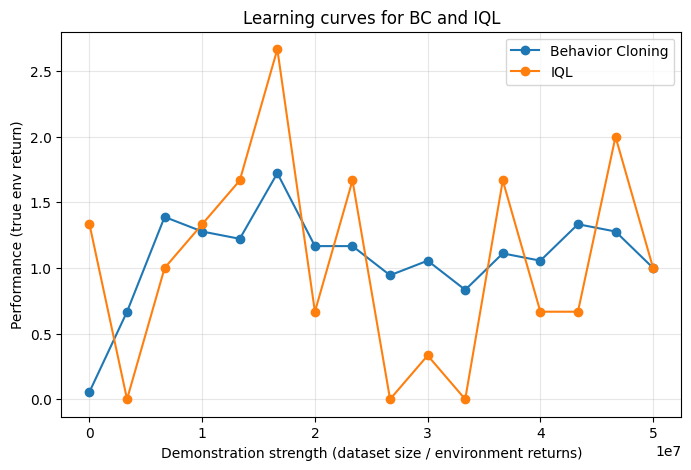


Expert Models:
  TREX: None
  CLASSIFIER_BC: 18.0
  IQL: 3.0
{'TREX': None, 'CLASSIFIER_BC': 18.0, 'IQL': 3.0}


In [8]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np

INDEX_PATH = "../../comparison_outputs/index.json"

# Load index
with open(INDEX_PATH, "r") as f:
    index = json.load(f)

# Storage
trex_strength = []
trex_return = []
bc_strength = []
bc_return = []
iql_strength = []
iql_return = []

# Expert scores (no numeric suffix)
expert_scores = {
    "TREX": None,
    "CLASSIFIER_BC": None,
    "IQL": None,
}

# Regex to extract trailing number from filenames
number_regex = re.compile(r".*?_(\d+)\.npz$")

for entry in index:
    algo = entry["algo"]            # "TREX" or "CLASSIFIER_BC"
    fname = entry["dataset_name"]   # e.g. "policy_params_6666752.npz"
    reward = entry["avg_reward"]

    match = number_regex.match(fname)

    if match is None:
        # Expert model (no number in filename)
        expert_scores[algo] = reward
        print(f"Found expert for {algo}: reward={reward}")
        continue

    # Extract number
    strength = int(match.group(1))

    # Store depending on algo
    if algo == "TREX":
        trex_strength.append(strength)
        trex_return.append(reward)
    elif algo == "CLASSIFIER_BC":
        bc_strength.append(strength)
        bc_return.append(reward)
    elif algo == "IQL":
        iql_strength.append(strength)
        iql_return.append(reward)

# Convert to sorted curves
trex_sorted = sorted(zip(trex_strength, trex_return))
bc_sorted = sorted(zip(bc_strength, bc_return))
iql_sorted = sorted(zip(iql_strength, iql_return))

trex_strength, trex_return = zip(*trex_sorted) if trex_sorted else ([], [])
bc_strength, bc_return = zip(*bc_sorted) if bc_sorted else ([], [])
iql_strength, iql_return = zip(*iql_sorted) if iql_sorted else ([], [])

# --- Plot ---
plt.figure(figsize=(8,5))

if trex_strength:
    plt.plot(trex_strength, trex_return, marker="o", label="T-REX")

if bc_strength:
    plt.plot(bc_strength, np.array(bc_return)/expert_scores["CLASSIFIER_BC"], marker="o", label="Behavior Cloning")

if iql_strength:
    plt.plot(iql_strength, np.array(iql_return)/expert_scores["IQL"], marker="o", label="IQL")

plt.xlabel("Demonstration strength (dataset size / environment returns)")
plt.ylabel("Performance (true env return)")
plt.title("Learning curves for BC and IQL")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print expert scores at the end
print("\nExpert Models:")
for algo, score in expert_scores.items():
    print(f"  {algo}: {score}")

print(expert_scores)